# Transformer for Text Classification

## Importing Packages

In [2]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [4]:
# Step 1: Load and preprocess the IMDB dataset
vocab_size = 10000  # Only use the top 10,000 words
max_len = 200  # Max length of each sequence

In [5]:
# Load the dataset
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=vocab_size)

17464789/17464789 [==============================] - 2s 0us/step


In [6]:
# Pad sequences to ensure uniform input size
X_train = pad_sequences(X_train, maxlen=max_len, padding="post", truncating="post")
X_test = pad_sequences(X_test, maxlen=max_len, padding="post", truncating="post")

In [7]:
# Step 2: Positional Encoding function
def positional_encoding(sequence_length, d_model):
    positions = np.arange(sequence_length)[:, np.newaxis]
    dimensions = np.arange(d_model)[np.newaxis, :]
    angle_rates = 1 / np.power(10000, (2 * (dimensions // 2)) / d_model)
    angle_rads = positions * angle_rates

    # Apply sin to even indices, cos to odd indices
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    return tf.constant(angle_rads, dtype=tf.float32)


## Step 3: Define the Transformer components

In [9]:
class MultiHeadSelfAttention(layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadSelfAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // num_heads

        self.wq = layers.Dense(d_model)
        self.wk = layers.Dense(d_model)
        self.wv = layers.Dense(d_model)

        self.dense = layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.split_heads(self.wq(q), batch_size)
        k = self.split_heads(self.wk(k), batch_size)
        v = self.split_heads(self.wv(v), batch_size)

        matmul_qk = tf.matmul(q, k, transpose_b=True)

        dk = tf.cast(tf.shape(k)[-1], tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

        if mask is not None:
            scaled_attention_logits += (mask * -1e9)

        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)

        output = tf.matmul(attention_weights, v)
        output = tf.transpose(output, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(output, (batch_size, -1, self.d_model))
        return self.dense(concat_attention)

In [11]:
class TransformerBlock(layers.Layer):
    def __init__(self, d_model, num_heads, ff_dim, dropout=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadSelfAttention(d_model, num_heads)
        self.ffn = tf.keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(d_model)]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(dropout)
        self.dropout2 = layers.Dropout(dropout)

    def call(self, inputs, mask=None):
        attn_output = self.att(inputs, inputs, inputs, mask)
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)


## Step 4: Build the Transformer-based model

In [12]:
def create_transformer_model(vocab_size, max_len, d_model, num_heads, ff_dim):
    inputs = layers.Input(shape=(max_len,))
    x = layers.Embedding(vocab_size, d_model)(inputs)
    x += positional_encoding(max_len, d_model)

    transformer_block = TransformerBlock(d_model, num_heads, ff_dim)
    x = transformer_block(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(50, activation="relu")(x)
    x = layers.Dropout(0.1)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

## Step 5: Instantiate and train the model

In [13]:
d_model = 128
num_heads = 4
ff_dim = 128

model = create_transformer_model(vocab_size, max_len, d_model, num_heads, ff_dim)
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [15]:
history = model.fit(
    X_train,
    y_train,
    epochs=3,
    batch_size=64,
    validation_data=(X_test, y_test),
)

Epoch 1/3
391/391 [==============================] - 115s 294ms/step - loss: 0.1576 - accuracy: 0.9406 - val_loss: 0.4202 - val_accuracy: 0.8414
Epoch 2/3
391/391 [==============================] - 114s 292ms/step - loss: 0.1027 - accuracy: 0.9640 - val_loss: 0.5541 - val_accuracy: 0.8366
Epoch 3/3
391/391 [==============================] - 117s 299ms/step - loss: 0.0572 - accuracy: 0.9810 - val_loss: 0.6965 - val_accuracy: 0.8255


In [16]:
# Step 6: Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.2f}")

782/782 [==============================] - 29s 38ms/step - loss: 0.6965 - accuracy: 0.8255
Test Accuracy: 0.83


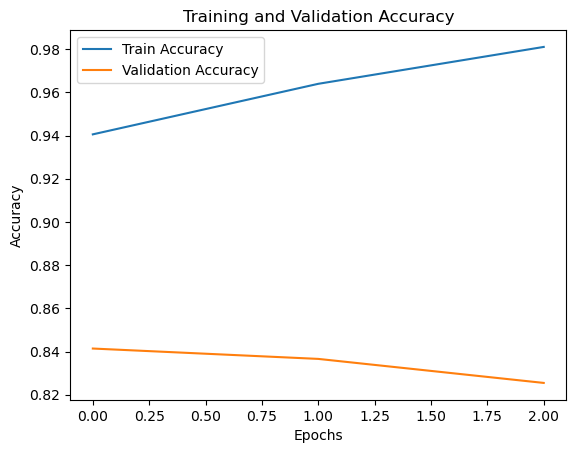

In [17]:
# Step 7: Visualize training history
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Implementing Language Translation

In [1]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from datasets import load_dataset

In [2]:
# Load a pre-trained Transformer model for English-to-French translation
model_name = "Helsinki-NLP/opus-mt-en-fr"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

C:\Users\furka\miniconda3\envs\tf01\Lib\site-packages\transformers\models\marian\tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


pytorch_model.bin:   0%|          | 0.00/301M [00:00<?, ?B/s]

C:\Users\furka\miniconda3\envs\tf01\Lib\site-packages\huggingface_hub\file_download.py:159: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\furka\.cache\huggingface\hub\models--Helsinki-NLP--opus-mt-en-fr. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

In [3]:
# Load a sample dataset
dataset = load_dataset("wmt14", "fr-en", split="test[:1%]")  # Using 1% of the test data
english_sentences = dataset["translation"][:10]  # Take the first 10 sentences

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/40836715 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3003 [00:00<?, ? examples/s]

In [4]:
# Translate English to French
for i, pair in enumerate(english_sentences):
    # Tokenize English sentence
    inputs = tokenizer(pair["en"], return_tensors="pt", truncation=True)
    
    # Generate translation
    outputs = model.generate(**inputs)
    french_translation = tokenizer.decode(outputs[0], skip_special_tokens=True)
    
    # Print results
    print(f"Sentence {i+1}:")
    print(f"  English: {pair['en']}")
    print(f"  French Translation: {french_translation}")
    print()

Sentence 1:
  English: Spectacular Wingsuit Jump Over Bogota
  French Translation: Spectaculaire Wingsuit Jump Over Bogota

Sentence 2:
  English: Sportsman Jhonathan Florez jumped from a helicopter above Bogota, the capital of Colombia, on Thursday.
  French Translation: Le sportif Jhonathan Florez a sauté d'un hélicoptère au-dessus de Bogota, la capitale de la Colombie, jeudi.

Sentence 3:
  English: Wearing a wingsuit, he flew past over the famous Monserrate Sanctuary at 160km/h. The sanctuary is located at an altitude of over 3000 meters and numerous spectators had gathered there to watch his exploit.
  French Translation: Portant un wingsuit, il a survolé le célèbre Sanctuaire Monserrate à 160km/h. Le sanctuaire est situé à une altitude de plus de 3000 mètres et de nombreux spectateurs s'y étaient rassemblés pour observer son exploit.

Sentence 4:
  English: A black box in your car?
  French Translation: Une boîte noire dans votre voiture ?

Sentence 5:
  English: As America's roa

# Saving File

In [14]:
# Example of an absolute path
output_file = "C:/Users/furka/Desktop/developer/code/python/doing_datascience/results/translation_results_ab.txt"

# Example of a relative path
#output_file = "./results/translation_results.txt"  # Saves in the 'results' folder

In [15]:
# Optional: Save translations to a file
with open(output_file, "w") as f:
    for i, pair in enumerate(english_sentences):
        inputs = tokenizer(pair["en"], return_tensors="pt", truncation=True)
        outputs = model.generate(**inputs)
        french_translation = tokenizer.decode(outputs[0], skip_special_tokens=True)
        f.write(f"Sentence {i+1}:\nEnglish: {pair['en']}\nFrench: {french_translation}\n\n")